<a href="https://colab.research.google.com/github/bharathi-srini/Bayesian_Inference_Recommender_Systems/blob/master/basket_context_embeddings_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q talos

In [2]:
from keras.models import Model
from keras.layers.core import Dense, Reshape, Lambda
from keras.layers import Input, Embedding, concatenate, Multiply
from keras import backend as K
from keras import optimizers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import preprocessing
from keras.regularizers import l2
import random
from keras.layers.advanced_activations import LeakyReLU
import keras
import time
import talos

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8032693382003372332
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10542756990309162850
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11606741484732254143
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8280643457038445211
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = 'gdrive/My Drive/BNN_RecSys/'

In [0]:
df_use = pd.read_csv(root_path+"data_100.csv")

In [7]:
# Number of product IDs available
N_products = df_use['product_id'].nunique()
N_shoppers = df_use['user_id'].nunique()

print(N_products,N_shoppers )

6018 100


In [0]:
EMBEDDING_COLUMNS = ["user_id", "product_id"]

In [0]:
#Helper to index columns before embeddings
def val2idx(df, cols):
    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x]+1)

    unique_vals = dict()
    for c in cols:
        unique_vals[c] = df[c].nunique()

    return df, unique_vals

In [0]:
df_deep, unique_vals = val2idx(df_use, EMBEDDING_COLUMNS)

In [11]:
df_deep.shape

(39973, 14)

In [0]:
def first_prod(order):
    for _,row in order.iterrows():
        if row['add_to_cart_order']==1:
            return row['product_id']

In [0]:
def next_prod(order):
    for _,row in order.iterrows():
        if row['add_to_cart_order']==2:
            return row['product_id']

In [0]:
def transform_data_for_embedding(df):
    first = df.groupby(['order_id']).apply(first_prod)
    next_product = df.groupby(['order_id']).apply(lambda x:next_prod(x))
    basket =df.groupby(['order_id', 'product_id']).size().unstack(fill_value=0)
    transform_df = pd.DataFrame(first, columns = ['first_prod'])
    transform_df['next_product']= next_product.values
    transform_df.reset_index(inplace=True)

    # Number of product IDs available
    N_products = df['product_id'].nunique()
    N_shoppers = df['user_id'].nunique()

    return transform_df, basket, N_products, N_shoppers

In [15]:
%time
df1, basket, N_products, N_shoppers = transform_data_for_embedding(df_deep)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.3 µs


In [0]:
def create_input_for_embed_network(df, transform_df, basket, N_products):

    # Creating df with order_id, user_id, first prod, next prod, basket 
    x = df.drop_duplicates(subset=['order_id','user_id'])
    train_df = pd.merge(transform_df, x[['order_id','user_id']], how='left', on='order_id' )
    train_df.dropna(inplace=True)
    
    basket.reset_index(inplace=True)
    basket_df = pd.merge(train_df[['order_id']], basket, how='left', on ='order_id')
    basket_df.drop(['order_id'], axis=1, inplace=True)

    train_df['next_product'] = train_df['next_product'].astype('category', categories = df.product_id.unique())
    y_df = pd.get_dummies(train_df, columns = ['next_product'])
    y_df.drop(['user_id','order_id','first_prod'], axis=1, inplace=True)

    return train_df['first_prod'], train_df['user_id'], basket_df, y_df

In [17]:
time_start = time.clock()
product_in , user_in, basket_in, predicted_product = create_input_for_embed_network(df_deep, df1, basket, N_products)
print(time.clock() - time_start)

1.3297930000000004


In [18]:
print(user_in.shape, product_in.shape, basket_in.shape, predicted_product.shape)

product_tr, product_te, predicted_tr, predicted_te, index_train, index_test = train_test_split(product_in, predicted_product,product_in.index, test_size=0.20,\
                                                                    random_state=42)

(3329,) (3329,) (3329, 6018) (3329, 6018)


In [0]:
user_tr = user_in[index_train]
user_te = user_in[index_test]

basket_tr = basket_in.loc[index_train]
basket_te = basket_in.loc[index_test]

In [20]:
# Integer IDs representing 1-hot encodings
prior_in = Input(shape=(1,))
shopper_in = Input(shape=(1,))

# Dense N-hot encoding for candidate products
candidates_in = Input(shape=(N_products,))

# Embeddings
prior = Embedding(N_products+1, 10)(prior_in)
shopper = Embedding(N_shoppers+1, 10)(shopper_in)

# Reshape and merge all embeddings together
reshape = Reshape(target_shape=(10,))
combined = keras.layers.concatenate([reshape(prior), reshape(shopper)])

# Hidden layers
#hidden_1 = Dense(1024, activation='relu',W_regularizer=l2(0.02))(combined)
#hidden_2 = Dense(512, activation='relu',W_regularizer=l2(0.02))(hidden_1)
hidden_3 = Dense(256, activation='relu')(combined)
hidden_4 = Dense(128, activation='relu')(hidden_3)

# Final 'fan-out' into the space of future products
final = Dense(N_products, activation='relu')(hidden_4)
#LR_final = LeakyReLU(alpha=0.1)(final)

# Ensure we do not overflow when we exponentiate
final = Lambda(lambda x: x - K.max(x))(final)

# Masked soft-max using Lambda and merge-multiplication
exponentiate = Lambda(lambda x: K.exp(x))(final)
masked = keras.layers.multiply([exponentiate, candidates_in])
predicted = Lambda(lambda x: x / K.sum(x))(masked)

# Compile with categorical crossentropy and adam
mdl = Model(input=[prior_in , shopper_in, candidates_in],
            output=predicted)
mdl.compile(loss='categorical_crossentropy', 
            optimizer=optimizers.Adam(lr=0.00001, clipnorm = 1.0, amsgrad=False),
            metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
start = time.clock()
out = mdl.fit([product_tr , user_tr, basket_tr], predicted_tr ,batch_size=512,
                    epochs=100,
                    verbose=0,
                    validation_data=[[product_te , user_te, basket_te], predicted_te])
print(time.clock() - start)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
92.030412


In [22]:
def embeddings_model(prior_val=product_te , shopper_val=user_te, candidates_val=basket_te,\
                     predicted_val=predicted_te,prior_in , shopper_in, candidates_in, predicted, params):
    # Integer IDs representing 1-hot encodings
    prior_in = Input(shape=(1,))
    shopper_in = Input(shape=(1,))

    # Dense N-hot encoding for candidate products
    candidates_in = Input(shape=(N_products,))

    # Embeddings
    prior = Embedding(N_products+1, 10)(prior_in)
    shopper = Embedding(N_shoppers+1, 10)(shopper_in)

    # Reshape and merge all embeddings together
    reshape = Reshape(target_shape=(10,))
    combined = keras.layers.concatenate([reshape(prior), reshape(shopper)])

    # Hidden layers
    hidden_1 = Dense(params['first_neuron'], activation=params['activation'])(combined)
    hidden_2 = Dense(params['second_neuron'], activation=params['activation'])(hidden_1)

    # Final 'fan-out' into the space of future products
    final = Dense(N_products, activation='relu')(hidden_4)

    # Ensure we do not overflow when we exponentiate
    final = Lambda(lambda x: x - K.max(x))(final)

    # Masked soft-max using Lambda and merge-multiplication
    exponentiate = Lambda(lambda x: K.exp(x))(final)
    masked = keras.layers.multiply([exponentiate, candidates_in])
    predicted = Lambda(lambda x: x / K.sum(x))(masked)

    # Compile with categorical crossentropy and adam
    mdl = Model(input=[prior_in , shopper_in, candidates_in],
            output=predicted)
    mdl.compile(loss='categorical_crossentropy',\
            optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
            metrics=['accuracy'])
    
    out = model.fit([prior_in , shopper_in, candidates_in], predicted,batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[[product_val , user_val, basket_val], predicted_val])
    
    return out, mdl

SyntaxError: ignored

In [0]:
p = {'lr': (0.1, 1, 10),
     'first_neuron':[512, 256, 128],
     'second_neuron':[256, 128, 64],
     'batch_size': [100, 1000, 10000],
     'epochs': [25, 50, 100],
     'dropout': (0, 0.10, 0.2),
     'optimizer': [Adam, Nadam],
     'loss': ['categorical_crossentropy'],
     'activation': ['relu', 'softplus','tanh']}

In [0]:
h = ta.Scan([product_tr , user_tr, basket_tr], predicted_tr, params=p,
            model=embeddings_model,
            dataset_name='instacrt',
            experiment_no='1',
            grid_downsample=.01)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [24]:
model_json = mdl.to_json()
with open("drive/BNN_RecSys/NN_embed_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
mdl.save_weights("drive/BNN_RecSys/NN_embed_model_weights.h5")
print("Saved model to drive")

Saved model to drive


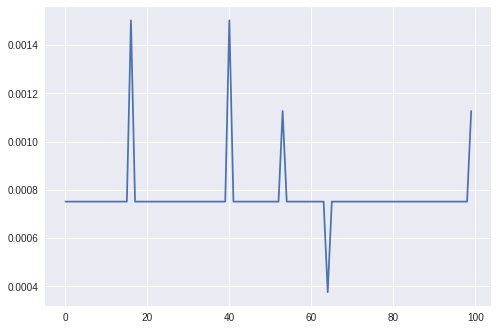

In [25]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(out.history['acc'])
plt.show()